In [2]:
import fitsio
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.table as t
# importing all modules
import os
import fitsio
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import numpy as np
import astropy.table as t
import subprocess
import json 
import scipy.optimize as so
from scipy.integrate import odeint
import numpy.ma as ma
from scipy.stats import linregress
import pandas as pd
from scipy.stats import binned_statistic as bn

In [3]:
# checking which tiles have truth tables
trutab=t.Table.read('/global/cfs/cdirs/desi/sv/vi/TruthTables/Fuji/ELG/220505_ELG_SV1_blanc_and_Fuji_v1.csv')
trutab2=t.Table.read('/global/cfs/cdirs/desi/sv/vi/TruthTables/Fuji/LRG/220505_LRG_SV1_blanc_and_Fuji_v1.csv')
print(np.unique(trutab2['TILEID']))
print(np.unique(trutab['TILEID']))

TILEID
------
 80605
 80609
TILEID
------
 80606
 80608
 80610


In [4]:
#demo tile (filename) taken from Rafaella'S code
# filename='/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80618/20210328/emline-1-80618-thru20210328.fits'

In [44]:
#filenames for tiles with truth tables
emlist=glob.glob('/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80610/*/emline*.fits')

In [45]:
len(emlist)

10

In [46]:
# reading each fits file in emfit output
for filename in emlist:
    emread1= fitsio.FITS(filename)
print(emread1[1].read_header())


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  345 / width of table in bytes
NAXIS2  =                  500 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   80 / number of fields in each row
TTYPE1  = 'TARGETID'           / label for field   1
TFORM1  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE2  = 'Z'                  / label for field   2
TFORM2  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE3  = 'ZWARN'              / label for field   3
TFORM3  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE4  = 'SPECTYPE'           / label for field   4
TFORM4  = '6A'                 / data format of field: ASCII Character
TTYPE5  = 'DELTACHI2'          / label for f

In [47]:
# reading each fits file in emfit output 2
emtable=t.Table()
for filename in emlist:
    emread2=fits.open(filename)
    dumtable=t.Table.read(emread2[1])
    emtable=t.vstack([dumtable,emtable])

In [48]:
len(emtable)

5000

(array([3897.,    0.,    0.,    0.,    0.,  911.,    0.,    0.,    0.,
         192.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

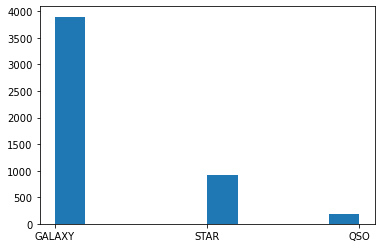

In [49]:
spectype=emtable['SPECTYPE']
zwarn=emtable['ZWARN'][spectype=='GALAXY']
delchi2=emtable['DELTACHI2'][spectype=='GALAXY']
flo2=emtable['OII_FLUX'][spectype=='GALAXY']
sigo2=emtable['OII_SIGMA'][spectype=='GALAXY']
flo3=emtable['OIII_FLUX'][spectype=='GALAXY']
sigo3=emtable['OIII_SIGMA'][spectype=='GALAXY']
ivaro2=emtable['OII_FLUX_IVAR'][spectype=='GALAXY']
ivaro3=emtable['OIII_FLUX_IVAR'][spectype=='GALAXY']
plt.hist(spectype)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   3.,   1.,  12.,
        526., 434., 267., 153.,  95.,  60.,  45.,  40.,  25.,  16.,  15.,
         15.,  10.,  11.,  10.,   6.,   6.,   7.,   7.,   3.,   3.,   4.,
          2.,   2.,   2.,   2.,   3.,   2.,   2.,   1.,   0.,   1.,   0.,
          3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   1., 

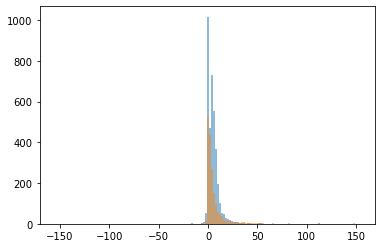

In [50]:
plt.hist(flo2/sigo2,bins=np.arange(-155,155,2),alpha=0.5)
plt.hist(flo3/sigo3,bins=np.arange(-155,155,2),alpha=0.5)

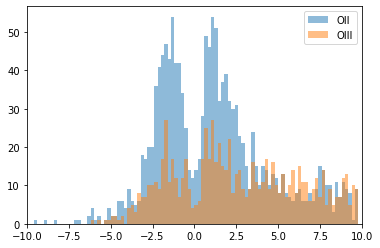

In [51]:
plt.hist(flo2*ivaro2**0.5,bins=np.arange(-10,10,.2),alpha=0.5,label='OII')
plt.hist(flo3*ivaro3**0.5,bins=np.arange(-10,10,.2),alpha=0.5,label='OIII')
plt.xlim(-10,10)
plt.legend()

0.025749423520368946
0.021137586471944657


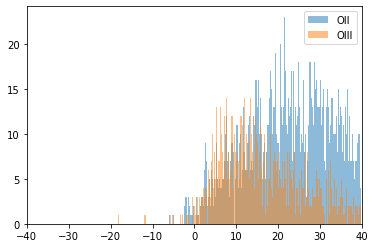

In [60]:
good=(zwarn==0)&(delchi2>40)
plt.hist(flo2[good]*ivaro2[good]**0.5,bins=np.arange(-40,40,.2),alpha=0.5,label='OII')
plt.hist(flo3[good]*ivaro3[good]**0.5,bins=np.arange(-40,40,.2),alpha=0.5,label='OIII')
plt.xlim(-40,40)
plt.legend()
print(np.sum(flo2[good]*ivaro2[good]**0.5<3)/np.sum(good))
print(np.sum(flo3[good]*ivaro3[good]**0.5<3)/np.sum(good))

6
2602


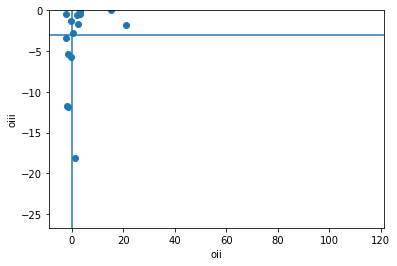

In [81]:
plt.scatter(flo2[good]*ivaro2[good]**0.5,flo3[good]*ivaro3[good]**0.5)
# plt.xlim(right=0)
plt.ylim(top=0)
plt.xlabel('oii')
plt.ylabel('oiii')
plt.axvline(0)
plt.axhline(-3)
print(np.sum((flo2[good]*ivaro2[good]**0.5>-3) & (flo3[good]*ivaro3[good]**0.5<-3)))
print(np.sum(good))


Text(0, 0.5, 'oiii')

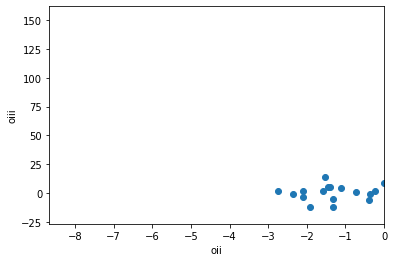

In [70]:
plt.scatter(flo2[good]*ivaro2[good]**0.5,flo3[good]*ivaro3[good]**0.5)
plt.xlim(right=0)
plt.xlabel('oii')
plt.ylabel('oiii')

In [53]:
p['Z'].data

NameError: name 'p' is not defined

In [33]:
plt.hist(a/b)

NameError: name 'a' is not defined

In [10]:
# determine pull distribution of OIII and OII lines in the data

tiles = [80618]
nights = [20210328]

def read_redrock_cat(tile,night):
    # read redrock catalog of given tile, night
    return None

def read_emlinefit_cat(tile,night):
    return None

def select_all_galaxies(redrock_cat):
    # return indices of all galaxy fibers (see Raffaella's notebook)
    return []

def select_good_galaxies(redrock_cat):
    # return indices of all high fidelity redshift galaxy fibers (see Raffaella's notebook)
    return []

pulls_oIII = []
pulls_oIII_good = []
pulls_oII  = []
pulls_oII_good = []

for tile,night in zip(tiles,nights):
    redrock_cat = read_redrock_cat(tile,night)
    emlinefit_cat = read_emlinefit_cat(tile,night)
    
    all_galaxies = select_all_galaxies(redrock_cat)
    good_galaxies = select_good_galaxies(redrock_cat)
    
    pulls_oIII.append(emlinefit_cat[all_galaxies]['OIII_FLUX']/emlinefit_cat[all_galaxies]['OIII_SIGMA'])
    # and four more like this for the other pulls
    # may or may not have to subtract the continuum (also in the catalog) from the flux - best may be to look at emlinefit code
    
plt.hist(pulls_oIII)
# add a Gaussian here to the histogram, normalized by twice the number of negative pulls

# and three more
    
plt.scatter(pulls_oIII,pulls_oII)
# maybe fit an ellipse == determine the covariance of these two quantities, maybe just from the negative side (ignoring cases where both are positive?)
# the fact that the oII penalty is already in effect limits the usefulness of this test
# (but maybe the oII penalty is not implemented right)

# if this test shows a significant population of negative OIII outliers that are not also OII outliers,
# that is clear indication we can gain by dealing with that in the fit

# if this test does not show that, the next test may be to do the same on the model (which could show that the model is unphysical, even without coincidence of absorption lines in the data and oIII wavelength in the fit)



TypeError: 'NoneType' object is not subscriptable